# Bài toán xác định bài viết bán hàng 
 
### Tóm tắt yêu cầu:
Xác định một bài viết trên mạng xã hội có phải là bán hàng hay không?
### Bộ dữ liệu:
60.000 dòng trạng thái trên mạng xã hội đã được gẵn nhãn bán hàng hay không.

## Thực hiện

### Tiền xử lí dữ liệu

Thêm các thư viện cần sử dụng:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

Đọc dữ liệu đầu vào và tách ra những data bán hàng và không bán hàng
Nhìn qua bộ dữ liệu, chuyển các nhãn thành số:
* 1 = không bán hàng
* 0 = bán hàng

In [2]:
SELL = '__label__post_ban_hang'
NON_SELL = '__label__post_khong_ban'
data  = pd.read_csv('./data/data_original.txt', header = None, sep="\n")
tmp = data[0].str.split(" ", 1, expand = True)
df = pd.DataFrame(columns=['label', 'content'])
data['label'] = tmp[0]
data['content'] = tmp[1]
data.drop([data.columns[0]], axis='columns', inplace=True)
Encoder = LabelEncoder()
data['label'] = Encoder.fit_transform(data['label'])
data.head(5)

label                                            content
0      1  Gsu khsi nek dep gai hk cho y kirn yk nhoaz kh...
1      1              Haiz ... chan wa. hoc-hoc-nua-hoc mau
2      1                                 Găng tay ngập shop
3      0  🌺 2 siểu phẩm XÔNG BẮC THẢO DƯỢC 🌺 ( Công dụng...
4      1                               Nổi nhớ dân trào 😂😂😂

Số lượng dữ liệu và từng loại label:
* Bán hàng: 7935 (chiếm 13.2%)
* Không bán hàng: 52065 (chiếm 86.8%)

In [3]:
data.groupby('label').count()

content
label         
0         7935
1        52065

Xem những từ xuất hiện nhiều trên bộ dữ liệu:

In [4]:
%run ./pre-process/top_words
top_words(data['content'].tolist(), file_name = 'top_before_pre')

<Figure size 640x480 with 1 Axes>

Làm đẹp dữ liệu text qua các bước:
* Chuyển thành kí tự viết thường
* Loại bỏ các emoji
* Chuyển đổi các định dạng giá cả $\Rightarrow$ __giá_sản_phẩm__
   * Ví dụ: 500k, 500.000đ, 500.000vnđ, 5m, 5tr6, ...
* Chuyển đổi link website 	$\Rightarrow$ __link_website__
   * Toàn bộ link bắt đầu từ http, https, bit.ly, goo.gl
* Chuyển đổi các dạng số điện thoại 	$\Rightarrow$ __số_điện_thoại__
   * Ví dụ: +84946.123.45, 096-265-222, 096.265.222, ...
* Xóa các dấu câu, kí tự lạ.
* Xoá kí tự số
* Tokenizer
   * Chuyển các từ ghép có nghĩa thành một từ: xin chào $\rightarrow$ __xin_chào__, tóm tắt $\rightarrow$ __tóm_tắt__, kính đổi màu $\rightarrow$ __kính_đổi_màu__ ... 
* Xóa các data NaN

In [5]:
%run ./pre-process/pre_process
data['content'] = data['content'].map(lambda s : pre_process(s))
data.dropna()

Loading model from file pre-process/vi-segmentation.crfsuite


label                                            content
0          1  gsu khsi nek dep gai hk cho y kirn yk nhoaz kh...
1          1                   haiz chan wa hoc hoc nua hoc mau
2          1                                 găng_tay ngập shop
3          0  siểu phẩm xông bắc thảo_dược công_dụng từng lo...
4          1                                   nổi nhớ dân trào
...      ...                                                ...
59995      1                                     còn ít mầu nữa
59996      0  đầm xòe cổ sen sát_nách chất da cá sỉ giá_sản_...
59997      1           người đẹp chuyển giới thái lan biểu_diễn
59998      1  do not understand why this walking throughout ...
59999      1  hòa chung không_khí rộn_ràng của cả nước u23 v...

[60000 rows x 2 columns]

In [6]:
data['content'][10:30]

10    sữa rửa mặt ohui miracle moisture sữa rửa mặt ...
11    chuc mừng sinh_nhật chj le nguyen em tuong vy ...
12    clutch đà_điểu sang_trọng cho nam call số_điện...
13    quần_jean chân viền ren hoa giá_sản_phẩm chất ...
14               mới_đó mà đã chủ_nhật cuối tuần vui_vẻ
15                                    nkìn a từ fía sau
16                                       chuc thu sn vv
17                         quả set up xấu thê_thảm nhất
18                         vẫn người chụp ảnh có tâm ấy
19    đầm ren hoa sang_trọng và tinh_tế và thanh_lịc...
20    kam on may pn to chuc sn mk tuy muon nhưng mk ...
21    một ngày lễ thật vui và ý_nghĩa chúc tất_cả th...
22    hom nay la ngay vui ve nhat cua gia dinh da co...
23                 hay tu nhien va vo tu nhu vay tot ko
24    tàn_nhang bẩm_sinh đã hết nhờ thảo_dược hồng h...
25    bộ đồ_chơi xúc xắc giá giá_sản_phẩm có số_lượn...
26                                                     
27    code ngày mã code2103 lông_vũ locke thần v

Sau khi đã xử lí dữ liệu text, xem những từ xuất hiện nhiều nhất trong bộ dữ liệu:

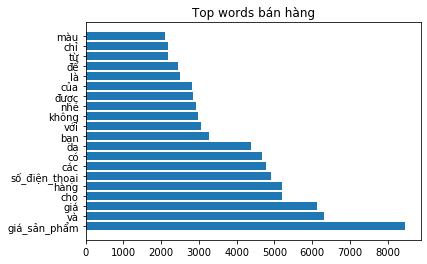

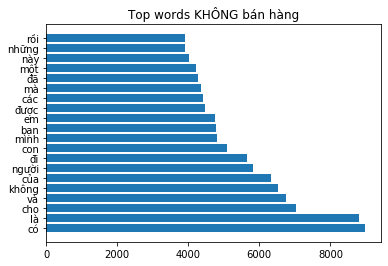

In [7]:
%run ./pre-process/top_words
two_top_words(data, file_name = 'top_after_pre')


Khi nhìn vào biểu đồ những từ xuất hiện nhiều trong dữ liệu, ta dễ dàng thấy một số từ không mang tính phân loại hoặc từ không mang nhiều ý nghĩa, ví dụ: *và*, *là*, *có*, *cho*, ...

Tiến hành loại bỏ những từ này bằng cách sử dụng bộ từ điển *stopwords*

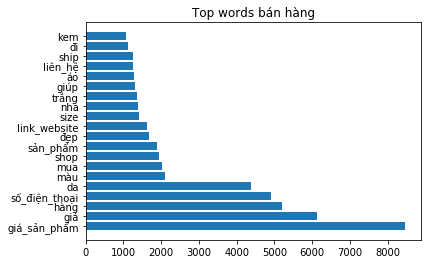

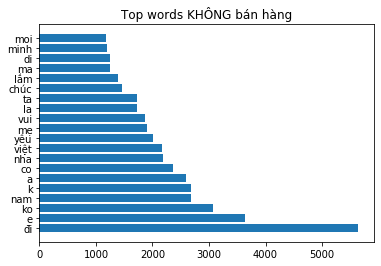

In [8]:
%run ./pre-process/top_words

stopwords = set(line.strip() for line in open('pre-process/stopwords.txt'))
data['content'] = data['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
two_top_words(data, file_name = 'top_after_pre')


Vector hóa, train và đánh giá phương pháp:

In [9]:
# Tách dữ liệu thành tập train và test
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(data['content'], data['label'],test_size=0.3, random_state=42)

# Vecto hóa dùng TF-IDF Vectorizer
Tfidf_vect = TfidfVectorizer(max_features=5000, lowercase=False)
Tfidf_vect.fit(data['content'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [10]:
# Phân loại dùng Naive Bayes và SVM để so sánh

# Naive Bayes
# fit tập train 
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# dự đoán
predictions_NB = Naive.predict(Test_X_Tfidf)

#  Tính Accuracy
print("Naive Bayes Accuracy -> ",accuracy_score(predictions_NB, Test_Y)*100)


# SVM
# fit tập train 
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

# dự đoán
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Tính Accuracy
print("SVM Accuracy -> ",accuracy_score(predictions_SVM, Test_Y)*100)

Naive Bayes Accuracy ->  96.83333333333334
SVM Accuracy ->  97.71111111111111


In [11]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(Test_Y, predictions_SVM)
print('Confusion matrix:')
print(cnf_matrix)

Confusion matrix:
[[ 2091   264]
 [  148 15497]]


In [12]:
TP = float(15249)
FP = float(232)
TN = float(2210)
FN = float(123)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2.0*(precision*recall)/(precision+recall)
F1

0.9884938255599132

In [13]:
Naive.predict(Tfidf_vect.transform([pre_process("""hôm nay tôi mệt""")]))


array([1])

In [14]:
Naive.predict(Tfidf_vect.transform([pre_process("""Cái áo này giá 600k bạn nhé :D""")]))

array([0])

## Đoạn sau này thử thôi, đừng bận tâm

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies

# # Load the data and create document vectors
# corpus = load_hobbies()
# tfidf = TfidfVectorizer()

# X = tfidf.fit_transform(corpus.data)
# y = corpus.target

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(Train_X_Tfidf, Train_Y)
tsne.show()

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,1,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    doc_len1 = [len(str(d)) for d in data_sells]
    doc_len2 = [len(str(d)) for d in data_nonsells]
    doc_lens = doc_len1 + doc_len2
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [ ]:
import collections
import re
import matplotlib.pyplot as plt

# file = open('../data/sell.csv', 'r')
# file = file.read()
from matplotlib.pyplot import figure
figure(num=None, figsize=(50, 40), dpi=80, facecolor='w', edgecolor='k')
doc_len = collections.defaultdict(int)
""" 
the next paragraph does all the counting and is the main point of difference from the original article. More on this is explained later.
"""
# \W is regex for characters that are not alphanumerics.
# all non-alphanumerics are replaced with a blank space using re.sub
def cal_len(data):
    for line in data:
        l = int(len(line.split())/10)*10
        if l < 1000:
            doc_len[l] += 1
        else:
            doc_len[1000] +=1
    return doc_len

d = cal_len(data_nonsells[0])

# # printing most common words
# to_print = 25
# # the next line sorts the default dict on the values in decreasing  # order and prints the first "to_print".
# mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print] # this is continued from the previous assignment
# for word, count in mc:
#     print(word, ":", count)

mc = sorted(d.items(), key=lambda k_v: k_v[0], reverse=True)

def loai(var):
    return var[1] > 10

mc = filter(loai,mc)
# Draw the bar chart
mc = dict(mc)
names = list(mc.keys())
values = list(mc.values())

plt.barh(range(len(mc)),values,tick_label=names)
plt.savefig('bar2.png')
plt.show()
mc
